# Response Distributions

Lets look at the answer distributions for each of the 3 questions in out survey.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stats_utils import *
import copy
from db_utils import query_analytics_store,query_hive_ssh


/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [37]:
def get_std_err(num_events, num_trials):
    dist =  get_beta_dist(num_events, num_trials, num_samples = 5000)
    ci = bayesian_ci(dist, 95)
    return (ci[1]-ci[0]) / 2
def get_std_err_series(s):
    n = s.sum()
    return s.apply(lambda x: get_std_err(x, n))

def recode_host(h):
    if h == 'en.m.wikipedia.org':
        return 'mobile'
    if h == 'en.wikipedia.org':
        return 'desktop'
    else:
        return None
    

def plot_proportion(d, x, hue, title,  xorder = None, drop_no_response = True, rotate = False):
    
    if drop_no_response:
        d = d[d[x] != 'no_response']
    else:
        xorder.append('no_response')
    
    d_in = pd.DataFrame({'count' : d.groupby( [x, hue] ).size()}).reset_index()
    d_in['err'] = d_in.groupby(hue).transform(get_std_err_series)
    d_in['proportion'] = d_in.groupby(hue).transform(lambda x: x/x.sum())['count']
    
    d_exp = pd.DataFrame()
    counts = d_in.groupby(hue)['count'].sum()
    for i, r in d_in.iterrows():
    
        n = counts[r[hue]]
        n1 = r['count']
        n0  =n - n1
        r_new = r[[x, hue]]
        r_new['in_data'] = 1
        d_exp = d_exp.append([r_new]*n1,ignore_index=True)
        r_new['in_data'] = 0
        d_exp = d_exp.append([r_new]*n0,ignore_index=True)
        
    fig = sns.barplot(
                x = x,
                y = 'in_data',
                data=d_exp,
                hue = hue,
                order = xorder,
                color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939)
                )
    plt.ylabel('Proportion')
    plt.title(title)
    
    if rotate:
        plt.xticks(rotation=45) 



In [27]:
d = pd.read_csv('../../data/clean_responses.tsv', sep = '\t')

query = """
SELECT
    webHost AS host,
    event_surveyInstanceToken as token
FROM 
    log.QuickSurveysResponses_15266417
WHERE
    event_surveyResponseValue ='ext-quicksurveys-external-survey-yes-button'
    AND webHost in ('en.m.wikipedia.org', 'en.wikipedia.org')
"""

d_click = query_analytics_store( query, {})
d = d.merge(d_click, how = 'left', on = 'token')
d['host'] = d['host'].apply(recode_host)
d_desktop = d[d['host'] == 'mobile']
d_mobile = d[d['host'] == 'desktop']
d_combined = d[d['host'].notnull()]
print('Num Responses: ', d.shape[0])
print('Num not in EL: ', d['host'].isnull().sum())
print('Num Mobile Responses in EL: ', d_desktop.shape[0])
print('Num Desktop Responses in EL: ', d_mobile.shape[0])

## Q1 Information Depth

I am reading this article to ... [Information Depth]
* look up a specific fact or to get a quick answer. [fact]
* get an overview of the topic. [overview]
* get an in-depth understanding of the topic. [in-depth]

### Information Depth Histogram

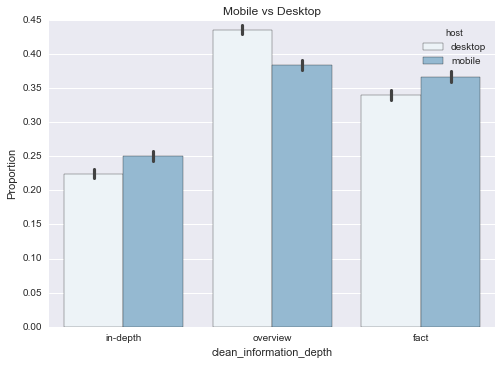

In [29]:
y = 'proportion'
x = 'clean_information_depth'
hue = 'host'
title = 'Mobile vs Desktop'
xorder = order = ['in-depth', 'overview', 'fact']
plot_proportion(d_combined, x, hue, title,  xorder = xorder)

## Q2 Familiarity

Prior to visiting this article ... [Prior Knowledge]
* I was already familiar with the topic. [familiar]
* I was not familiar with the topic and I am learning about it for the first time. [unfamiliar]

### Prior Knowledge Histogram

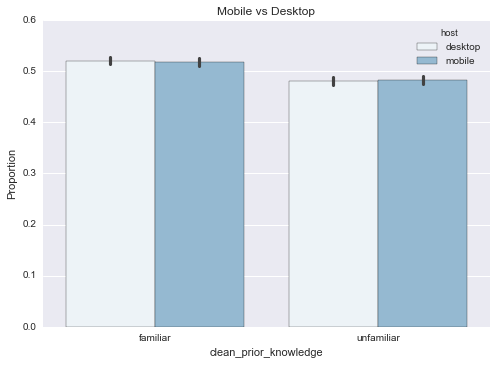

In [31]:
x = 'clean_prior_knowledge'
hue = 'host'
title = 'Mobile vs Desktop'
plot_proportion(d_combined, x, hue, title)

## Q3 Motivation

I am reading this article because ... [Motivation]
* I have a work or school-related assignment. [work/school]
* I need to make a personal decision based on this topic (e.g., to buy a  book or game, to choose a travel destination). [personal-decision]
* I want to know more about a current event (e.g. Black Friday, a soccer game, a recent earthquake, somebody's death). [current event]
* the topic was referenced in a piece of media (e.g. TV, radio, article, film, book). [media]
* the topic came up in a conversation. [conversation]
* I am bored or randomly exploring Wikipedia for fun. [bored/random]
* this topic is important to me and I want to learn more about it. (e.g., to learn about a culture). [intrinsic_learning]

### Number of Motivations Distribution

Subjects were allowed to select multiple reasons. How many motivations do people select?

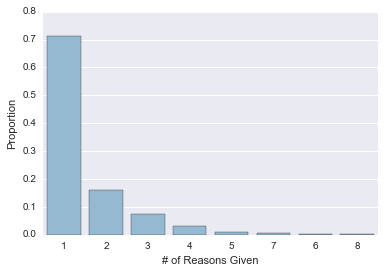

In [316]:
d_in = pd.DataFrame()
d_in['counts'] = d['clean_motivation'].apply(lambda x: len(x.split('|'))).value_counts()
d_in['proportion'] = d_in['counts'] / d_in['counts'].sum()

d_in['# Motivations'] = d_in.index
#order = ['familiar', 'unfamiliar']
#d_in = d_in.loc[order]

fig = sns.barplot(y="proportion",
            x = '# Motivations',
            data=d_in,
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939)
            )
plt.ylabel('Proportion')
plt.xlabel('# of Reasons Given')

30% of respondents listed more than one motivation.

### Motivation Histogram

For each motivation lets count how often it was chosen as at least on of the motivations.

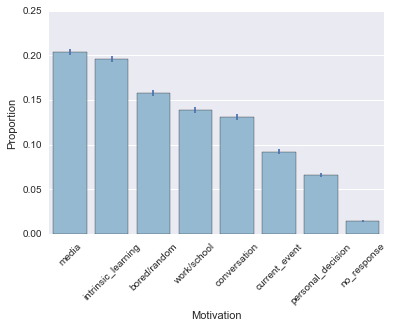

In [317]:
d_in = pd.DataFrame(columns = ['motivation', 'counts'])
ms = [
        'work/school',
        'personal_decision',
        'current_event',
        'media',"conversation",
        'bored/random',
        'no_response',
        'intrinsic_learning',
    ]

for i, m in enumerate(ms):
     d_in.loc[i] = [m, d['clean_motivation'].apply(lambda x: m in x).sum()]




d_in['proportion'] = d_in['counts'] / d_in['counts'].sum()
d_in['err'] = d_in['counts'].apply(lambda x: get_std_err(x, d_in['counts'].sum()))
d_in.sort_values(by = 'counts', inplace = True, ascending = False)
fig = sns.barplot(y="proportion",
            x = 'motivation',
            data=d_in,
            yerr = d_in['err'],
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939),
            )
plt.ylabel('Proportion')
plt.xlabel('Motivation')

for item in fig.get_xticklabels():
    item.set_rotation(45)

Media and intrinsic learning are the most popular and very close

### Single Motivation Histogram

For responses with only a single motivation, what is the distribution over motivations.

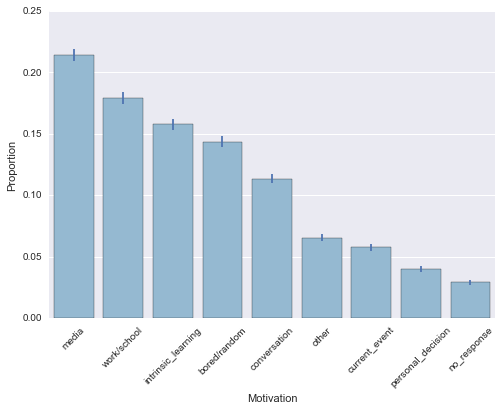

In [34]:
d_single_motivation = d[d['clean_motivation'].apply(lambda x: len(x.split('|')) == 1)]

d_in = pd.DataFrame()
d_in['counts'] = d_single_motivation['clean_motivation'].value_counts()
d_in['proportion'] = d_in['counts'] / d_in['counts'].sum()
d_in['prior_knowledge'] = d_in.index
d_in['err'] = d_in['counts'].apply(lambda x: get_std_err(x, d_in['counts'].sum()))

fig = sns.barplot(y="proportion",
            x = 'prior_knowledge',
            data=d_in,
            yerr = d_in['err'],
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939),
            )
plt.ylabel('Proportion')
plt.xlabel('Motivation')

for item in fig.get_xticklabels():
    item.set_rotation(45)


Media appears more prominently now that we only look at users who chose a single motivation.

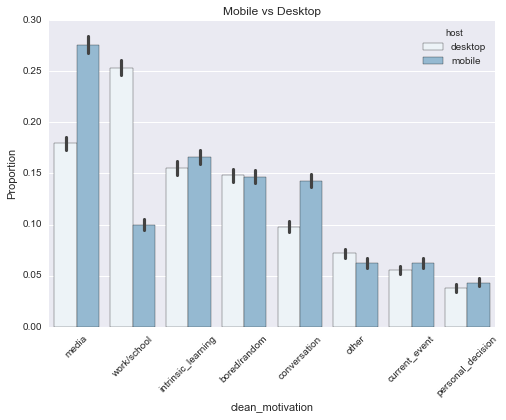

In [42]:
x = 'clean_motivation'
hue = 'host'
title = 'Mobile vs Desktop'
order = ['media', 'work/school','intrinsic_learning', 'bored/random', 'conversation', 'other','current_event', 'personal_decision', ]
plot_proportion(d_single_motivation, x, hue, title, xorder = order, rotate=True)

### Double Motivation Co-occurrence Heatmaps

For users who chose 2 motivations, which motivations co-occur?

In [319]:
df = copy.deepcopy(d[d['clean_motivation'].apply(lambda x: len(x.split('|')) == 2)])
df['pm'] = df['clean_motivation'].apply(lambda x: '|'.join(sorted(x.split('|'))))
df_joint = pd.DataFrame()
df_joint['count'] = df['pm'].value_counts()
df_joint['pm'] = df_joint.index
df_joint.index = range(0, df_joint.shape[0])
df_joint['m1'] = df_joint['pm'].apply(lambda x: x.split('|')[0])
df_joint['m2'] = df_joint['pm'].apply(lambda x: x.split('|')[1])
df_joint['count'] = df_joint['count'].apply(int)

In [320]:
df_joint2 = copy.deepcopy(df_joint)
df_joint2['pm'] = df_joint2['pm'].apply(lambda x: '|'.join(sorted(x.split('|'), reverse = True)))
df_joint2['m1'] = df_joint2['pm'].apply(lambda x: x.split('|')[0])
df_joint2['m2'] = df_joint2['pm'].apply(lambda x: x.split('|')[1])
df_joint2.index = range(df_joint.shape[0], 2 * df_joint.shape[0])

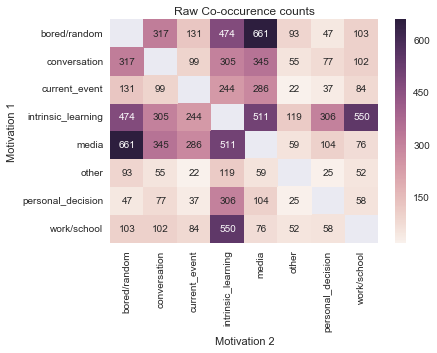

In [321]:
df_joint12 = pd.concat([df_joint, df_joint2]).pivot("m1", "m2", "count")
ax = sns.heatmap(df_joint12, annot=True, fmt="0.0f")
plt.ylabel('Motivation 1')
plt.xlabel('Motivation 2')
plt.title('Raw Co-occurence counts')

The since some motivations are more popular than others, the color coding can be misleading. Let's look at the conditional distributions instead.

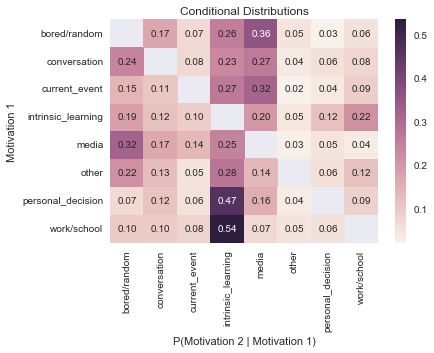

In [315]:
df_joint12_norm = df_joint12.div(df_joint12.sum(axis=1), axis=0)
ax = sns.heatmap(df_joint12_norm, annot=True, fmt="0.2f")
plt.ylabel('Motivation 1')
plt.xlabel('P(Motivation 2 | Motivation 1)')
plt.title('Conditional Distributions')

 - Given that work/school is a motivation, the most common other motivation is intrinsic_learning by a long shot. seems like people in our survey who choose 2 motivations like their job/studies
 - the pattern is similar for personal decisiions
 - Given that people are bored/randomly exploring, their most likely other motivations is media. the next most likely is intrinsic_learning
 - the pattern is similar for current events